## Comparative Spectral Classification Pipeline

Authors: 
- Fábio D. Pacheco, up202502538

Date: 24/11/2025

### Description

This notebook is used for the following purposes:

#### Comparative Spectral Classification Pipeline

In [192]:
import os
import glob
import random
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading bar
from tqdm         import tqdm
from tqdm_joblib  import tqdm_joblib

# sklearn
from sklearn.model_selection        import StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing          import StandardScaler
from sklearn.pipeline               import Pipeline
from sklearn.metrics                import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support 
from sklearn.metrics                import confusion_matrix, classification_report, log_loss
from sklearn.preprocessing          import LabelEncoder
from sklearn.calibration            import calibration_curve
from sklearn.base                   import BaseEstimator, TransformerMixin, clone
from sklearn.decomposition          import PCA

# Classifiers
from sklearn.neighbors              import KNeighborsClassifier
from sklearn.svm                    import SVC
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis

# Calibration
from sklearn.calibration            import CalibratedClassifierCV

# Savitzky–Golay
from scipy.signal                   import savgol_filter

# mRMR
from sklearn_mrmr.mrmr              import MRMRFeatureSelector

#### Dataset Loading

In [ ]:
dataset_dir_path = "../dataset/"

xtrain_path = dataset_dir_path + "xtrain.csv"
xtest_path  = dataset_dir_path + "xtest.csv"

ytrain_path = dataset_dir_path + "ytrain.csv"
ytest_path  = dataset_dir_path + "ytest.csv"

if( os.path.exists(xtrain_path) ):  X_train  = pd.read_csv( xtrain_path, index_col=0 )
if( os.path.exists(ytrain_path) ):  y_train_ = pd.read_csv( ytrain_path, index_col=0 )
if( os.path.exists(xtest_path) ):   X_test   = pd.read_csv( xtest_path, index_col=0 )
if( os.path.exists(ytest_path) ):   y_test_  = pd.read_csv( ytest_path, index_col=0 )

print(f"Train shape of X:{X_train.shape}, y:{y_train_.shape}")
print(f"Test  shape of X:{X_test.shape}, y:{y_test_.shape}")

le = LabelEncoder( )

y_train = le.fit_transform( y_train_["polymer"] )
y_test  = le.transform( y_test_["polymer"] )

Train shape of X:(839, 2151), y:(839, 1)
Test  shape of X:(210, 2151), y:(210, 1)


#### Savitzky–Golay Transformer

In [18]:
class SavitzkyGolayTransformer(BaseEstimator, TransformerMixin):
  def __init__(
    self, 
    window_length=15, 
    polyorder=2, 
    deriv=0
  ):
    self.window_length = window_length
    self.polyorder = polyorder
    self.deriv = deriv

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return savgol_filter(
      X,
      window_length=self.window_length,
      polyorder=self.polyorder,
      deriv=self.deriv,
      axis=1
    )


#### 1.) Preprocessing Selection Stage

In [ ]:
cv = StratifiedKFold(
  n_splits=8, 
  shuffle=True, 
  random_state=0
)

pipeline = Pipeline([
  ("sg", "passthrough"),
  ("scaler", StandardScaler()),
  ("mrmr", "passthrough"),
  ("pca", "passthrough"),
  ("clf", KNeighborsClassifier(
    n_neighbors=3,
    metric="euclidean"
  ))
])

param_grid = [
  # None
  {
    "sg":   ["passthrough"],
    "mrmr": ["passthrough"],
    "pca":  ["passthrough"],
  },

  # SG only
  {
    "sg":   [SavitzkyGolayTransformer(polyorder=1)],
    "mrmr": ["passthrough"],
    "pca":  ["passthrough"],
  },

  # PCA only
  {
    "sg":   ["passthrough"],
    "mrmr": ["passthrough"],
    "pca":  [PCA(n_components=0.99)],
  },

  # SG + PCA
  {
    "sg":   [SavitzkyGolayTransformer(polyorder=1)],
    "mrmr": ["passthrough"],
    "pca":  [PCA(n_components=0.99)],
  },

  # mRMR only
  {
    "sg":   ["passthrough"],
    "mrmr": [MRMRFeatureSelector(n_features_to_select=20, method="ftest")],
    "pca":  ["passthrough"],
  },

  # SG + mRMR
  {
    "sg":   [SavitzkyGolayTransformer(polyorder=1)],
    "mrmr": [MRMRFeatureSelector(n_features_to_select=20, method="ftest")],
    "pca":  ["passthrough"],
  },
]

grid_stage1 = GridSearchCV(
  pipeline,
  param_grid,
  scoring="balanced_accuracy",
  cv=cv,
  n_jobs=-1,
  return_train_score=False
)

n_candidates = len(param_grid)
total_fits = n_candidates * cv.get_n_splits( )
with tqdm_joblib(tqdm(desc="GridSearch preprocessing", total=total_fits)):
  grid_stage1.fit(X_train, y_train)

100%|██████████| 48/48 [01:41<00:00,  2.12s/it]


In [ ]:
cv_results = pd.DataFrame(grid_stage1.cv_results_)

cv_results[[
  "mean_test_score",
  "std_test_score",
  "param_sg",
  "param_mrmr",
  "param_pca"
]].sort_values( "mean_test_score", ascending=False )

best_stage1 = [ ]
best_stage1.append( cv_results.iloc[
  cv_results["mean_test_score"].idxmax()
])
best_stage1.append( cv_results.iloc[
  cv_results["std_test_score"].idxmin()
])

print("=== Max mean")
print( best_stage1[0].params )
print( "Mean: ", best_stage1[0].mean_test_score )
print( "Std:  ", best_stage1[0].std_test_score )
print( "Fit time mean (s): ", best_stage1[0].mean_fit_time )
print( "Fit time std (s): ", best_stage1[0].std_fit_time )

print("=== Min variance")
print( best_stage1[1].params )
print( "Accuracy mean: ", best_stage1[1].mean_test_score )
print( "Accuracy std:  ", best_stage1[1].std_test_score )
print( "Fit time mean (s): ", best_stage1[1].mean_fit_time )
print( "Fit time std (s): ", best_stage1[1].std_fit_time )


=== Max mean
{'mrmr': 'passthrough', 'pca': PCA(n_components=0.99), 'sg': SavitzkyGolayTransformer(polyorder=1)}
Mean:  0.8471260830027992
Std:   0.0375653793833751
Fit time mean (s):  3.7591810822486877
Fit time std (s):  0.5541723486868213
=== Min variance
{'mrmr': 'passthrough', 'pca': 'passthrough', 'sg': SavitzkyGolayTransformer(polyorder=1)}
Accuracy mean:  0.844730969587949
Accuracy std:   0.031527647407635404
Fit time mean (s):  0.24008944630622864
Fit time std (s):  0.06027216426724537


#### 2.) Preprocessing Hyperparameter Optimization Stage

In [ ]:
grids_stage2 = []
seen_params  = []
unique_best  = []

for best in best_stage1:
  if best.params not in seen_params:
    unique_best.append(best)
    seen_params.append(best.params)


for best in unique_best:
  pipeline = Pipeline([
    ("sg",    best.params["sg"]),
    ("scaler", StandardScaler()),
    ("mrmr",  best.params["mrmr"]),
    ("pca",   best.params["pca"]),
    ("clf",   KNeighborsClassifier(n_neighbors=3, metric="euclidean"))
  ])

  sg_list = ["passthrough"]
  if best.params["sg"] != "passthrough":
    sg_list = [
      SavitzkyGolayTransformer(window_length=201, polyorder=1, deriv=0), 
      SavitzkyGolayTransformer(window_length=201, polyorder=1, deriv=1),
      SavitzkyGolayTransformer(window_length=401, polyorder=1, deriv=0),
      SavitzkyGolayTransformer(window_length=401, polyorder=1, deriv=1),
      SavitzkyGolayTransformer(window_length=401, polyorder=2, deriv=0),
      SavitzkyGolayTransformer(window_length=401, polyorder=2, deriv=1)
    ]

  mrmr_list = ["passthrough"]
  if best.params["mrmr"] != "passthrough":
    mrmr_list = [
      MRMRFeatureSelector(n_features_to_select=40, method="ftest"),
      MRMRFeatureSelector(n_features_to_select=100, method="ftest"),
      MRMRFeatureSelector(n_features_to_select=200, method="ftest")
    ]

  pca_list = ["passthrough"]
  if best.params["pca"] != "passthrough":
    pca_list = [
      PCA(n_components=0.90),
      PCA(n_components=0.95),
      PCA(n_components=0.99),
      PCA(n_components=0.999),
      PCA(n_components=0.9999)
    ]

  param_grid = [{
    "sg": sg_list,
    "mrmr": mrmr_list,
    "pca": pca_list,
  }]

  grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    return_train_score=False
  )

  n_candidates = len(sg_list) * len(mrmr_list) * len(pca_list)
  total_fits = n_candidates * cv.get_n_splits()

  with tqdm_joblib( tqdm( desc="GridSearch preprocessing", total=total_fits ) ):
    grid.fit( X_train, y_train )

  grids_stage2.append( grid )

GridSearch preprocessing:   0%|          | 0/96 [00:00<?, ?it/s]


100%|██████████| 96/96 [01:51<00:00,  1.16s/it]



100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


In [86]:
best_stage2 = [ ]

for grid in grids_stage2: 
  cv_results = pd.DataFrame(grid.cv_results_)

  cv_results[[
    "mean_test_score",
    "std_test_score",
    "param_sg",
    "param_mrmr",
    "param_pca"
  ]].sort_values( "mean_test_score", ascending=False )

  opt = []

  opt.append( cv_results.iloc[
    cv_results["mean_test_score"].idxmax()
  ])
  opt.append( cv_results.iloc[
    cv_results["std_test_score"].idxmin()
  ])

  best_stage2.append( opt )

  print("=== Max mean")
  print( opt[0].params )
  print( "Mean: ", opt[0].mean_test_score )
  print( "Std:  ", opt[0].std_test_score )
  print( "Fit time mean (s): ", opt[0].mean_fit_time )
  print( "Fit time std (s): ", opt[0].std_fit_time )

  print("=== Min variance")
  print( opt[1].params )
  print( "Accuracy mean: ", opt[1].mean_test_score )
  print( "Accuracy std:  ", opt[1].std_test_score )
  print( "Fit time mean (s): ", opt[1].mean_fit_time )
  print( "Fit time std (s): ", opt[1].std_fit_time )


=== Max mean
{'mrmr': 'passthrough', 'pca': PCA(n_components=0.95), 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Mean:  0.9168467083584361
Std:   0.0370828831913902
Fit time mean (s):  3.586889773607254
Fit time std (s):  0.2549902371621424
=== Min variance
{'mrmr': 'passthrough', 'pca': PCA(n_components=0.999), 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Accuracy mean:  0.8570415233387201
Accuracy std:   0.020582263293456617
Fit time mean (s):  4.909534752368927
Fit time std (s):  1.0226899746928908
=== Max mean
{'mrmr': 'passthrough', 'pca': 'passthrough', 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Mean:  0.8532400877938635
Std:   0.019799229826236945
Fit time mean (s):  0.40205472707748413
Fit time std (s):  0.29010776412000744
=== Min variance
{'mrmr': 'passthrough', 'pca': 'passthrough', 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Accuracy mean:  0.8532400877938635
Accur

#### 3.) Classification Hyperparameter Optimization Stage

In [ ]:
grids_stage3 = []
seen_params  = []
unique_best  = []

for stage1 in best_stage2:
  for best in stage1: 
    if best.params not in seen_params:
      unique_best.append(best)
      seen_params.append(best.params)
      
for best in unique_best:
  pipeline = Pipeline([
    ("sg",    "passthrough"),
    ("scaler", StandardScaler()),
    ("mrmr",  "passthrough"),
    ("pca",   "passthrough"),
    ("clf",   "passthrough") 
  ])

  fixed_prepro = {
    "sg":   [best.params["sg"]],
    "mrmr": [best.params["mrmr"]], 
    "pca":  [best.params["pca"]]
  }

  param_grid = [
    # kNN
    { **fixed_prepro,
      "clf": [KNeighborsClassifier()],
      "clf__n_neighbors": [3, 5, 7, 9],
      "clf__metric": ['euclidean', 'manhattan', 'cosine'],
      "clf__weights": ['uniform', 'distance']
    },

    # SVM
    { **fixed_prepro,
      "clf": [SVC(probability=True, decision_function_shape="ovo", class_weight="balanced")],
      "clf__C": [0.1, 1, 10],
      "clf__kernel": ["linear", "rbf", "sigmoid"]
    },

    # LDA
    { **fixed_prepro,
      "clf": [LinearDiscriminantAnalysis()],
      "clf__solver": ["svd", "lsqr"]
    }
  ]

  grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1
  )

  # Calculate total fits: Sum of combinations in each dict * folds
  n_candidates = 0
  for pg in param_grid:
    combos = 1
    for key, values in pg.items():
      combos *= len(values)
    n_candidates += combos

  total_fits = n_candidates * cv.get_n_splits()

  with tqdm_joblib(tqdm(desc=f"Comparing Classifiers", total=total_fits)):
    grid.fit(X_train, y_train)

  grids_stage3.append(grid)






















100%|██████████| 24/24 [00:32<00:00,  1.36s/it]















































100%|██████████| 24/24 [00:29<00:00,  1.23s/it]

















Comparing Classifiers:   0%|          | 0/24 [00:30<?, ?it/s]




































100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


In [159]:
best_stage3 = [ ]

for grid in grids_stage3: 
  cv_results = pd.DataFrame(grid.cv_results_)
  cv_results['clf_name'] = cv_results['param_clf'].apply(lambda x: x.__class__.__name__)
  class_types = ['KNeighborsClassifier', 'SVC', 'LinearDiscriminantAnalysis']

  for clf in class_types:
    cv_results_per_class = cv_results[ cv_results['clf_name'] == clf ]
    if cv_results_per_class.empty :
      continue

    opt = []

    opt.append(cv_results_per_class.loc[ 
      cv_results_per_class["mean_test_score"].idxmax() 
    ])
    opt.append(cv_results_per_class.loc[ 
      cv_results_per_class["std_test_score"].idxmin( ) 
    ])

    best_stage3.append( opt )

    print("====== Model preprocessor")
    print(f"SG:   {opt[0].params.get('sg')}")
    print(f"PCA:  {opt[0].params.get('pca')}")
    print(f"mRMR: {opt[0].params.get('mrmr')}")

    print("====== Model classifier")
    print( clf )

    print("=== Max mean")
    print( opt[0].params )
    print( "Mean: ", opt[0].mean_test_score )
    print( "Std:  ", opt[0].std_test_score )
    print( "Fit time mean (s): ", opt[0].mean_fit_time )
    print( "Fit time std (s): ", opt[0].std_fit_time )

    print("=== Min variance")
    print( opt[1].params )
    print( "Accuracy mean: ", opt[1].mean_test_score )
    print( "Accuracy std:  ", opt[1].std_test_score )
    print( "Fit time mean (s): ", opt[1].mean_fit_time )
    print( "Fit time std (s): ", opt[1].std_fit_time )
    print( "" )


====== Model preprocessor
SG:   SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)
PCA:  PCA(n_components=0.95)
mRMR: passthrough
====== Model classifier
KNeighborsClassifier
=== Max mean
{'clf': KNeighborsClassifier(), 'mrmr': 'passthrough', 'pca': PCA(n_components=0.95), 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Mean:  0.8230019912657213
Std:   0.024620448395034314
Fit time mean (s):  3.766984671354294
Fit time std (s):  0.24188660921380484
=== Min variance
{'clf': KNeighborsClassifier(), 'mrmr': 'passthrough', 'pca': PCA(n_components=0.95), 'sg': SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)}
Accuracy mean:  0.8230019912657213
Accuracy std:   0.024620448395034314
Fit time mean (s):  3.766984671354294
Fit time std (s):  0.24188660921380484

====== Model preprocessor
SG:   SavitzkyGolayTransformer(deriv=1, polyorder=1, window_length=51)
PCA:  PCA(n_components=0.95)
mRMR: passthrough
====== Model classifier
SVC
=== Max mean

#### Train the best performer models 

In [163]:
best_stage3_models = []
seen_params  = []
unique_best  = []

for stage3_models in best_stage3:
  for model_params in stage3_models:
    if model_params.params not in seen_params:
      unique_best.append(model_params)
      seen_params.append(model_params.params)
      
for model_row in tqdm(unique_best, desc="Fitting Models"):
  params   = model_row.params
  clf      = params['clf']
  clf_type = model_row['clf_name']

  sg_desc   = f"Window{params['sg'].window_length}"        if hasattr(params['sg'], 'window_length')          else "noSG"
  sg_desc  += f"Poly{params['sg'].polyorder}"              if hasattr(params['sg'], 'polyorder')              else "noSG"
  pca_desc  = f"PCA{params['pca'].n_components}"           if hasattr(params['pca'], 'n_components')          else "NoPCA"
  mrmr_desc = f"mRMR{params['mrmr'].n_features_to_select}" if hasattr(params['mrmr'], 'n_features_to_select') else "NomRMR"

  model_name = f"{clf}_{sg_desc}_{pca_desc}_{mrmr_desc}"
  print(f"Fitting: {model_name} (Mean Acc: {model_row.mean_test_score:.3f}, Std Acc: {model_row.std_test_score:.3f})")

  # 3. Reconstruct the model
  # We use the pipeline structure from your last grid (they all share the same structure)
  # and set the parameters discovered in the search
  final_model = clone(pipeline).set_params(**params)
  final_model.fit(X_train, y_train)
  
  best_stage3_models.append({
    "name": model_name,
    "model": final_model,
    "params": params,
    "row": model_row
  })

Fitting: KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.823, Std Acc: 0.025)


Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.692, Std Acc: 0.031)


Fitting: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.490, Std Acc: 0.054)


Fitting: KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.744, Std Acc: 0.037)


Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.708, Std Acc: 0.033)


Fitting: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.687, Std Acc: 0.078)


Fitting: KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.751, Std Acc: 0.044)


Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.710, Std Acc: 0.032)


Fitting: LinearDiscriminantAnalysis()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.584, Std Acc: 0.029)



Fitting Models: 100%|██████████| 9/9 [00:39<00:00,  4.34s/it]


#### 4.) Calibration with Platt Scaling Stage

In [176]:
calibrated_models = []

for model_info in tqdm(best_stage3_models, desc="Calibrating Models"):
  model_template = clone(pipeline).set_params(**model_info['params'])
  
  # We use 'sigmoid' (Platt Scaling) or 'isotonic'. 
  # Sigmoid is safer for small/medium datasets.
  calibrator = CalibratedClassifierCV(
    estimator=model_template, 
    method='sigmoid', 
    cv=5  # This performs the internal K-Fold calibration
  )
  
  model_name = f"Calibrated_{model_info['name']}"
  
  print(f"Fitting: {model_name} (Mean Acc: {model_info['row'].mean_test_score:.3f}, Std Acc: {model_info['row'].std_test_score:.3f})")
  calibrator.fit(X_train, y_train)

  
  calibrated_models.append({
    "name": model_name,
    "model": calibrator,
    "original_model": model_info['model'],
    "original_row": model_info['row']
  })

Calibrating Models:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting: Calibrated_KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.823, Std Acc: 0.025)


Calibrating Models:  11%|█         | 1/9 [00:19<02:36, 19.62s/it]

Fitting: Calibrated_SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.692, Std Acc: 0.031)


Calibrating Models:  22%|██▏       | 2/9 [00:36<02:06, 18.13s/it]

Fitting: Calibrated_LinearDiscriminantAnalysis()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.490, Std Acc: 0.054)


Calibrating Models:  33%|███▎      | 3/9 [00:53<01:45, 17.63s/it]

Fitting: Calibrated_KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.744, Std Acc: 0.037)


Calibrating Models:  44%|████▍     | 4/9 [01:13<01:32, 18.59s/it]

Fitting: Calibrated_SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.708, Std Acc: 0.033)


Calibrating Models:  56%|█████▌    | 5/9 [01:33<01:15, 18.87s/it]

Fitting: Calibrated_LinearDiscriminantAnalysis()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.687, Std Acc: 0.078)


Calibrating Models:  67%|██████▋   | 6/9 [01:49<00:54, 18.09s/it]

Fitting: Calibrated_KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.751, Std Acc: 0.044)


Calibrating Models:  78%|███████▊  | 7/9 [01:52<00:26, 13.07s/it]

Fitting: Calibrated_SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.710, Std Acc: 0.032)


Calibrating Models:  89%|████████▉ | 8/9 [02:23<00:18, 18.69s/it]

Fitting: Calibrated_LinearDiscriminantAnalysis()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.584, Std Acc: 0.029)


Calibrating Models: 100%|██████████| 9/9 [02:44<00:00, 18.29s/it]


#### Metrics

In [171]:
class Metric:
  def __init__(
    self,
    model, 
    X_test, 
    y_test
  ):
    self.model = model
    self.X_test = X_test
    self.y_test = y_test.ravel()

    self.y_pred = None
    self.y_proba = None

  def predict( self ):
    self.y_pred = self.model.predict(self.X_test)
    self.y_proba = self.model.predict_proba(self.X_test)

  def classification_metrics(self):
    return {
      "accuracy": accuracy_score( self.y_test, self.y_pred ),
      "balanced_accuracy": balanced_accuracy_score( self.y_test, self.y_pred )
    }

  def classwise_metrics(self):
    precision, recall, f1, support = precision_recall_fscore_support(
      self.y_test,
      self.y_pred,
      average=None
    )

    return {
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "support": support,
      "confusion_matrix": confusion_matrix( self.y_test, self.y_pred ),
      "classification_report": classification_report( self.y_test, self.y_pred )
    }

  def probabilistic_metrics(self):
    return {
      "log_loss": log_loss(self.y_test, self.y_proba),
      "brier_score": self._multiclass_brier_score( self.y_test, self.y_proba  )
    }

  def _multiclass_brier_score(self, y_true, y_proba):
    n_classes = y_proba.shape[1]
    y_true_oh = np.eye(n_classes)[y_true]
    return np.mean(
      np.sum( 
        (y_proba - y_true_oh) ** 2, 
        axis=1
      )
    )

  def expected_calibration_error(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
      mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
      if np.any(mask):
        acc = correct[mask].mean()
        conf = confidences[mask].mean()
        ece += np.abs(acc - conf) * np.sum(mask) / len(confidences)

    return ece

  def plot_reliability_diagram(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    frac_pos, mean_conf = calibration_curve(
      correct, confidences, n_bins=n_bins
    )

    plt.figure(figsize=(5, 5))
    plt.plot(mean_conf, frac_pos, "o-", label="kNN")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
    plt.xlabel("Mean confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("Reliability Diagram")
    plt.grid(True)
    plt.legend()
    plt.show()

  def plot_confusion_matrix(self, normalize=True, cmap="Blues"):
    cm = self.classwise_metrics( )["confusion_matrix"]

    if normalize:
      cm = cm / cm.sum(axis=1, keepdims=True)
      title = "Normalized Confusion Matrix"
    else:
      title = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax)

    n_classes = cm.shape[0]
    ticks = np.arange(n_classes)

    ax.set(
      xticks=ticks,
      yticks=ticks,
      xlabel="Predicted label",
      ylabel="True label",
      title=title
    )

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i in range(n_classes):
      for j in range(n_classes):
        ax.text(
          j, i, format(cm[i, j], fmt),
          ha="center", va="center",
          color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.show()

  def evaluate(self):
    self.predict( )

    results = {
      "classification": self.classification_metrics(),
      "classwise": self.classwise_metrics(),
      "probabilistic": self.probabilistic_metrics(),
      "ece": self.expected_calibration_error(),
    }

    return results


Calibrated_KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR
 Original CV Balanced Accuracy: 0.8230
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.852381           0.859084

[Probabilistic & Calibration]
   log_loss  brier_score
0  1.167214     0.230476
ECE (Expected Calibration Error): 0.0448

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        46
           1       0.88      0.80      0.84        75
           2       0.87      0.91      0.89        53
           3       0.70      0.86      0.78        36

    accuracy                           0.85       210
   macro avg       0.85      0.86      0.85       210
weighted avg       0.86      0.85      0.85       210



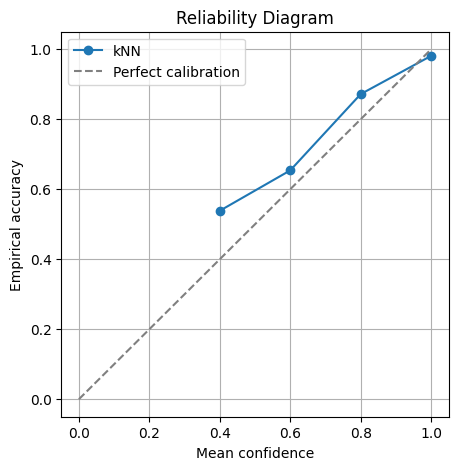

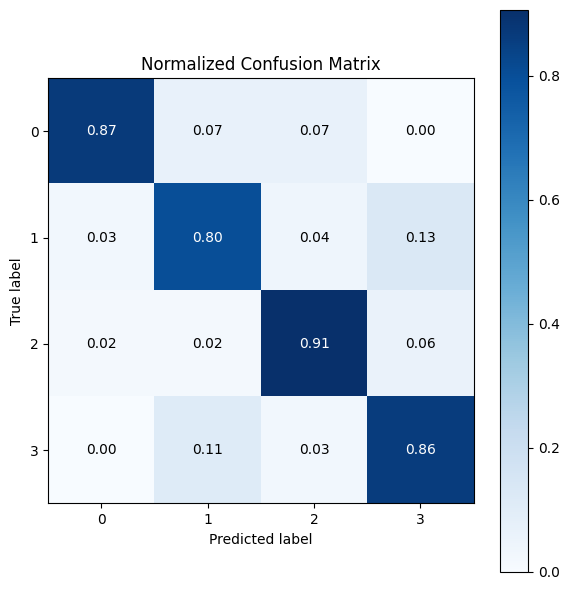

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.857143           0.853886

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.434721     0.221181
ECE (Expected Calibration Error): 0.0762

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        46
           1       0.82      0.85      0.84        75
           2       0.92      0.92      0.92        53
           3       0.73      0.83      0.78        36

    accuracy                           0.86       210
   macro avg       0.86      0.85      0.86       210
weighted avg       0.87      0.86      0.86       210



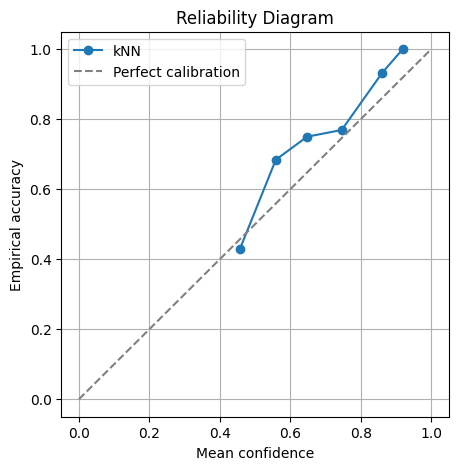

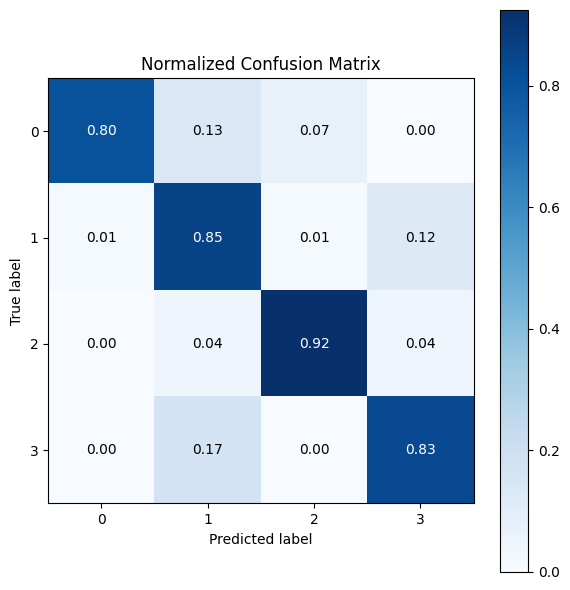


Calibrated_KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR
 Original CV Balanced Accuracy: 0.7507
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.785714           0.781139

[Probabilistic & Calibration]
   log_loss  brier_score
0  1.253809     0.290286
ECE (Expected Calibration Error): 0.0229

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        46
           1       0.78      0.79      0.78        75
           2       0.90      0.81      0.85        53
           3       0.62      0.72      0.67        36

    accuracy                           0.79       210
   macro avg       0.78      0.78      0.78       210
weighted avg       0.79      0.79      0.79       210



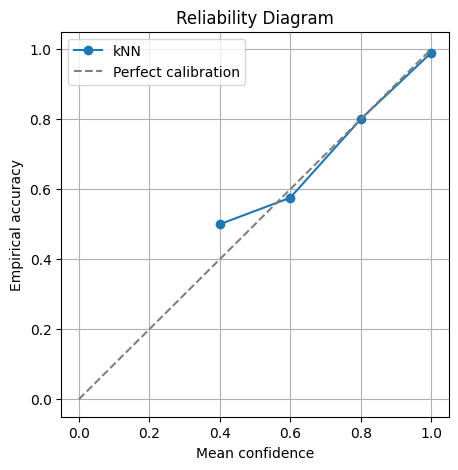

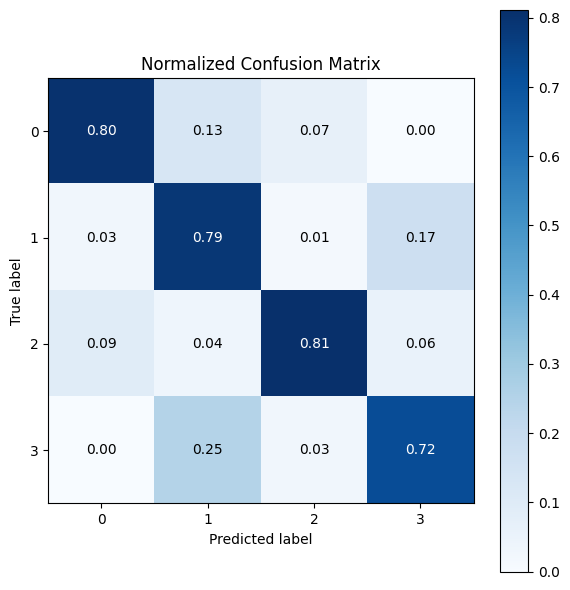

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.795238            0.78788

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.527287     0.278634
ECE (Expected Calibration Error): 0.0798

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        46
           1       0.78      0.81      0.80        75
           2       0.88      0.85      0.87        53
           3       0.63      0.75      0.68        36

    accuracy                           0.80       210
   macro avg       0.80      0.79      0.79       210
weighted avg       0.81      0.80      0.80       210



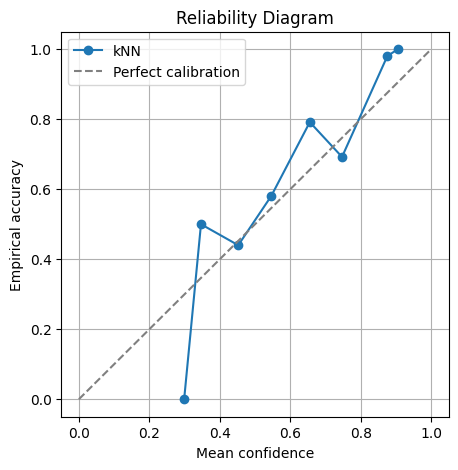

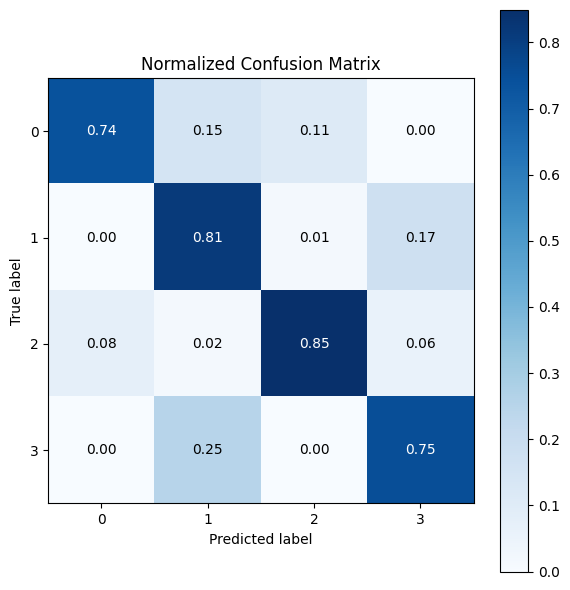


Calibrated_KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR
 Original CV Balanced Accuracy: 0.7445
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.790476           0.783755

[Probabilistic & Calibration]
   log_loss  brier_score
0  1.573783     0.289143
ECE (Expected Calibration Error): 0.0124

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        46
           1       0.79      0.80      0.79        75
           2       0.86      0.83      0.85        53
           3       0.63      0.72      0.68        36

    accuracy                           0.79       210
   macro avg       0.79      0.78      0.78       210
weighted avg       0.80      0.79      0.79       210



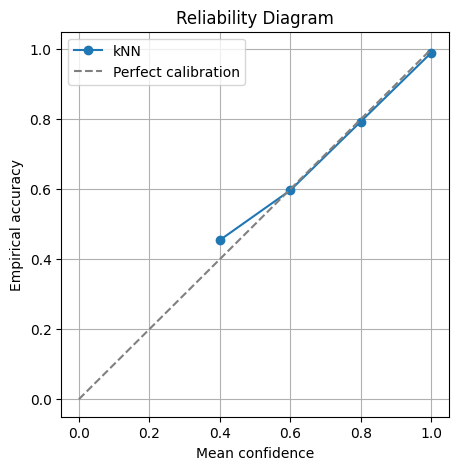

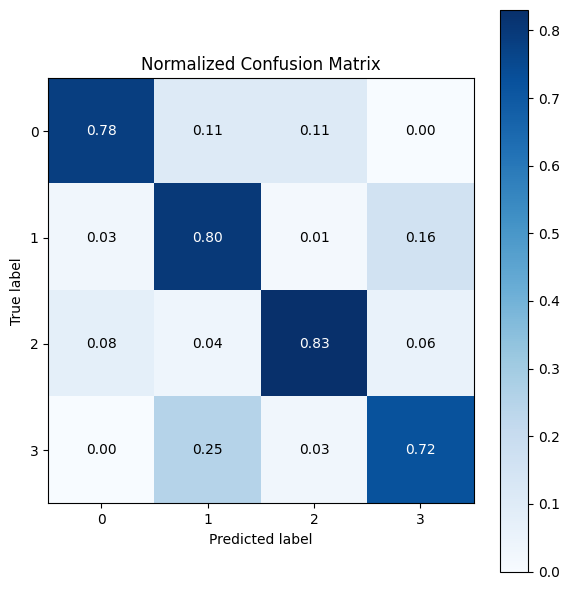

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.790476           0.775941

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.522219     0.274935
ECE (Expected Calibration Error): 0.1052

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        46
           1       0.77      0.84      0.80        75
           2       0.88      0.83      0.85        53
           3       0.64      0.69      0.67        36

    accuracy                           0.79       210
   macro avg       0.79      0.78      0.78       210
weighted avg       0.80      0.79      0.79       210



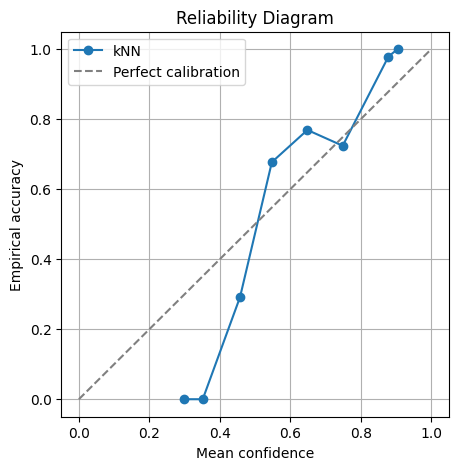

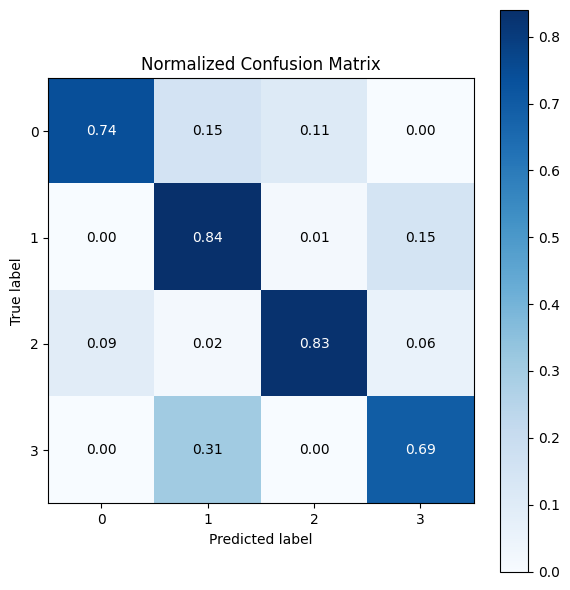

In [180]:
# Sort models by their original CV score to find the champions
sorted_finalists = sorted( calibrated_models, key=lambda x: x['original_row'].mean_test_score, reverse=True )
# Let's pick the Top 3 to avoid cluttering the output
top_finalists = sorted_finalists[:3]

models_to_test = ['original_model', 'model']

for i, model_info in enumerate(top_finalists):
  print(f"\n{'='*80}")
  print(model_info['name'])
  print(f" Original CV Balanced Accuracy: {model_info['original_row'].mean_test_score:.4f}")
  print(f"{'='*80}")

  for model_to_test in models_to_test:
    print(f"Model: for {model_to_test}")

    # Initialize the Metric class
    metric = Metric(
      model=model_info[ model_to_test ],
      X_test=X_test.values if hasattr(X_test, 'values') else X_test,
      y_test=y_test,
    )

    # Run evaluation
    results = metric.evaluate()

    # Display Classification & Probabilistic Metrics in tables
    print("\n[Overall Performance]")
    print(pd.DataFrame([results["classification"]]))

    print("\n[Probabilistic & Calibration]")
    print(pd.DataFrame([results["probabilistic"]]))
    print(f"ECE (Expected Calibration Error): {results['ece']:.4f}")

    # Display Classwise detailed report
    print("\n[Class-wise Report]")
    print(results["classwise"]["classification_report"])

    # Visualization
    metric.plot_reliability_diagram(n_bins=10)
    metric.plot_confusion_matrix(normalize=True, cmap="Blues")

### 5.) Test robustness and generalization with augmented data  

In [183]:
augmented_path = os.path.join(dataset_dir_path, "augmented/")
aug_files = glob.glob( os.path.join(augmented_path, "*.csv") )

def build_scenario_data(file_list, X_orig, y_orig):
  X_stack = [X_orig]
  y_stack = [y_orig]
  
  for f in file_list:
    X_aug = pd.read_csv(f, index_col=0)
    X_stack.append(X_aug)
    y_stack.append(y_orig)
    
  return pd.concat( X_stack, ignore_index=True ), np.concatenate( y_stack )

Test cases

In [184]:
scenarios = {
  #"Full_Augmented":    aug_files,
  #"Half_Augmented":    random.sample(aug_files, len(aug_files)//2),
  "Quarter_Augmented": random.sample(aug_files, len(aug_files)//4)
}

Perform the train with the test scenarios on the best performer models

In [190]:
aug_study = [ ]
agu_study_scenario = [ ]

for sc_name, sc_files in scenarios.items():
  print(f"\nscenario: {sc_name}")
  X_train_heavy, y_train_heavy = build_scenario_data(sc_files, X_train, y_train)
       
  for finalist in tqdm( best_stage3_models, desc=f"Training {sc_name}" ):
    model_template = clone(pipeline).set_params( **finalist['params'] )
    model_template.fit(X_train_heavy, y_train_heavy)
    
    print(f"Fitting: {finalist['name']} (Mean Acc: {finalist['row'].mean_test_score:.3f}, Std Acc: {finalist['row'].std_test_score:.3f})")

    calibrated_model = CalibratedClassifierCV(model_template, method='sigmoid', cv=5)
    calibrated_model.fit(X_train_heavy, y_train_heavy)

    print(f"Calibrating: {finalist['name']} (Mean Acc: {finalist['row'].mean_test_score:.3f}, Std Acc: {finalist['row'].std_test_score:.3f})")

    agu_study_scenario.append({
      "scenario": sc_name,
      "name": finalist['name'],
      "model": calibrated_model,
      "original_model": finalist['model'],
      "original_row": finalist['row'],
    })

  aug_study.append( agu_study_scenario )


scenario: Quarter_Augmented


Training Quarter_Augmented:   0%|          | 0/9 [00:00<?, ?it/s]

Fitting: KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.823, Std Acc: 0.025)


Training Quarter_Augmented:  11%|█         | 1/9 [04:51<38:54, 291.79s/it]

Calibrating: KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.823, Std Acc: 0.025)
Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.692, Std Acc: 0.031)


Training Quarter_Augmented:  22%|██▏       | 2/9 [10:42<38:05, 326.52s/it]

Calibrating: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.692, Std Acc: 0.031)
Fitting: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.490, Std Acc: 0.054)


Training Quarter_Augmented:  33%|███▎      | 3/9 [13:01<24:05, 240.92s/it]

Calibrating: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.95_NomRMR (Mean Acc: 0.490, Std Acc: 0.054)
Fitting: KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.744, Std Acc: 0.037)


Training Quarter_Augmented:  44%|████▍     | 4/9 [15:19<16:41, 200.32s/it]

Calibrating: KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.744, Std Acc: 0.037)
Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.708, Std Acc: 0.033)


Training Quarter_Augmented:  56%|█████▌    | 5/9 [18:58<13:47, 206.83s/it]

Calibrating: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.708, Std Acc: 0.033)
Fitting: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.687, Std Acc: 0.078)


Training Quarter_Augmented:  67%|██████▋   | 6/9 [21:20<09:15, 185.02s/it]

Calibrating: LinearDiscriminantAnalysis()_Window51Poly1_PCA0.999_NomRMR (Mean Acc: 0.687, Std Acc: 0.078)
Fitting: KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.751, Std Acc: 0.044)


Training Quarter_Augmented:  78%|███████▊  | 7/9 [21:38<04:20, 130.28s/it]

Calibrating: KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.751, Std Acc: 0.044)
Fitting: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.710, Std Acc: 0.032)


Training Quarter_Augmented:  89%|████████▉ | 8/9 [48:36<10:03, 603.88s/it]

Calibrating: SVC(class_weight='balanced', decision_function_shape='ovo', probability=True)_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.710, Std Acc: 0.032)
Fitting: LinearDiscriminantAnalysis()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.584, Std Acc: 0.029)


Training Quarter_Augmented: 100%|██████████| 9/9 [54:26<00:00, 362.99s/it]

Calibrating: LinearDiscriminantAnalysis()_Window51Poly1_NoPCA_NomRMR (Mean Acc: 0.584, Std Acc: 0.029)



KNeighborsClassifier()_Window51Poly1_PCA0.95_NomRMR
 Original CV Balanced Accuracy: 0.8230
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.857143           0.863675

[Probabilistic & Calibration]
   log_loss  brier_score
0  2.544483     0.223238
ECE (Expected Calibration Error): 0.0810

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        46
           1       0.86      0.79      0.82        75
           2       0.93      0.94      0.93        53
           3       0.68      0.83      0.75        36

    accuracy                           0.86       210
   macro avg       0.85      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



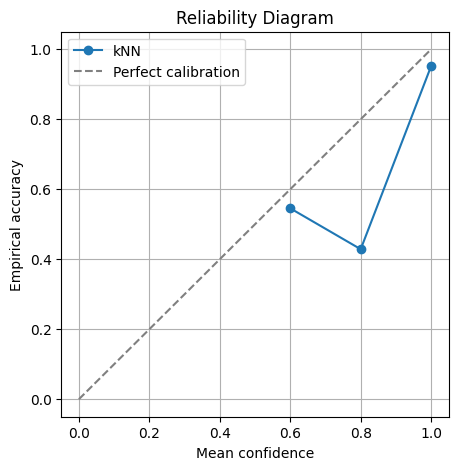

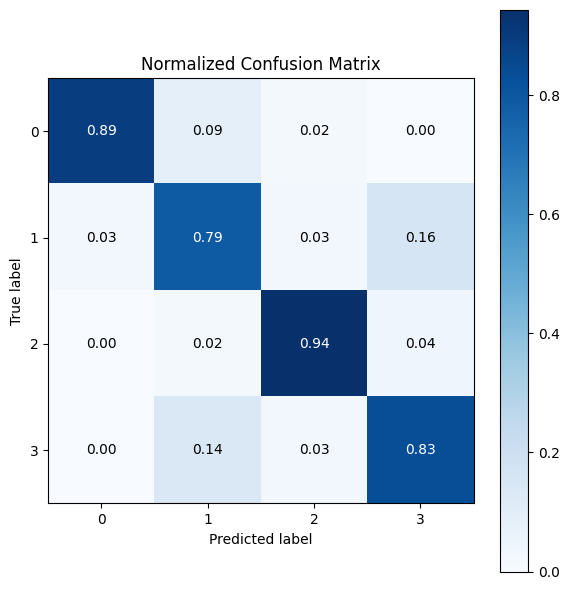

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.857143           0.863675

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.557967     0.227883
ECE (Expected Calibration Error): 0.0972

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        46
           1       0.87      0.79      0.83        75
           2       0.91      0.94      0.93        53
           3       0.68      0.83      0.75        36

    accuracy                           0.86       210
   macro avg       0.85      0.86      0.86       210
weighted avg       0.87      0.86      0.86       210



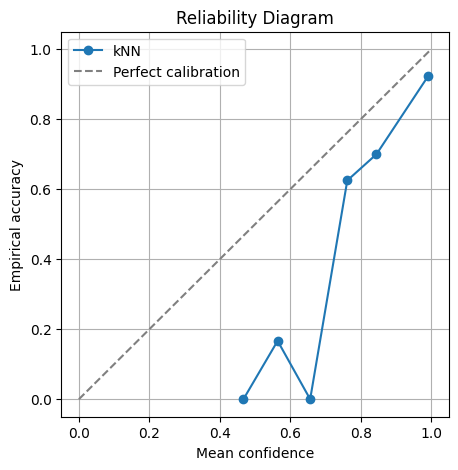

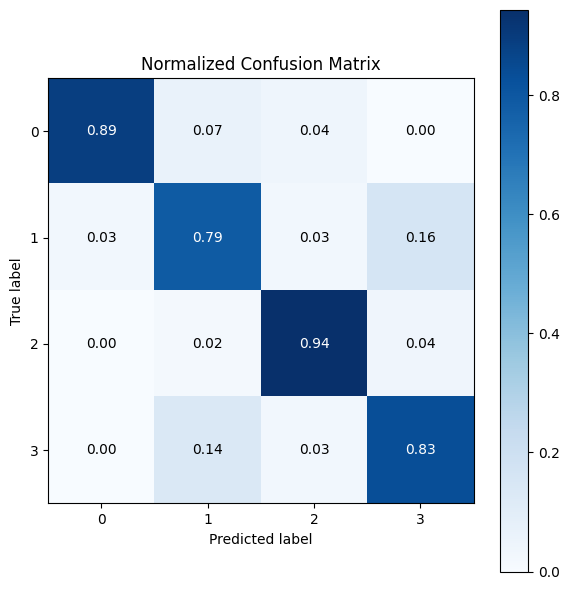


KNeighborsClassifier()_Window51Poly1_NoPCA_NomRMR
 Original CV Balanced Accuracy: 0.7507
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.819048           0.810599

[Probabilistic & Calibration]
   log_loss  brier_score
0    3.9197     0.286476
ECE (Expected Calibration Error): 0.1029

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        46
           1       0.80      0.81      0.81        75
           2       0.85      0.89      0.87        53
           3       0.66      0.69      0.68        36

    accuracy                           0.82       210
   macro avg       0.82      0.81      0.81       210
weighted avg       0.82      0.82      0.82       210



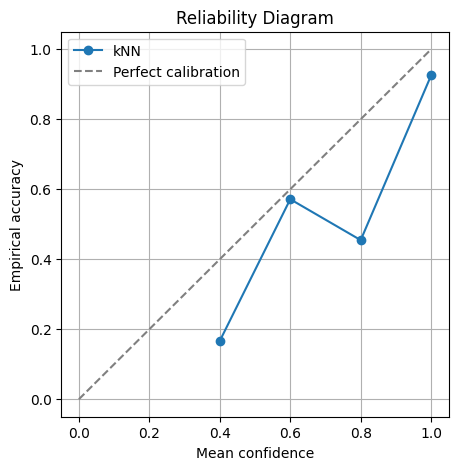

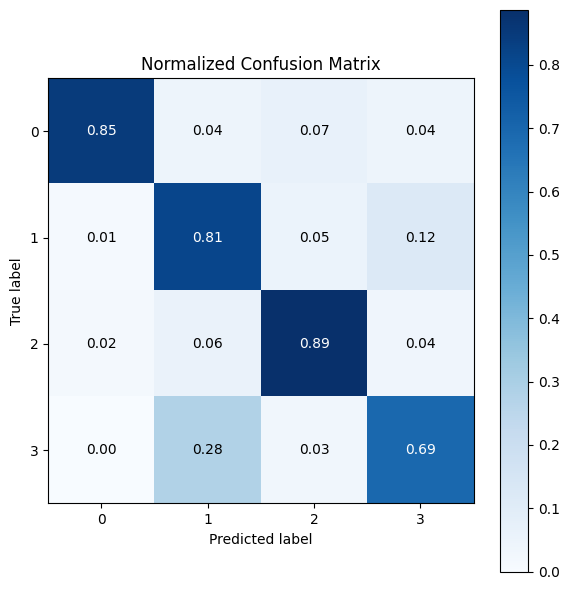

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.809524            0.80616

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.864398     0.310507
ECE (Expected Calibration Error): 0.1434

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        46
           1       0.82      0.79      0.80        75
           2       0.87      0.87      0.87        53
           3       0.59      0.72      0.65        36

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.80       210
weighted avg       0.82      0.81      0.81       210



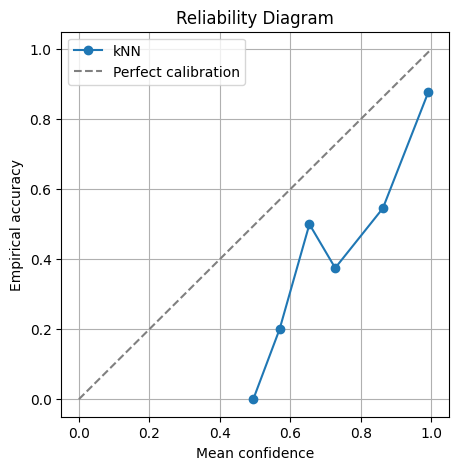

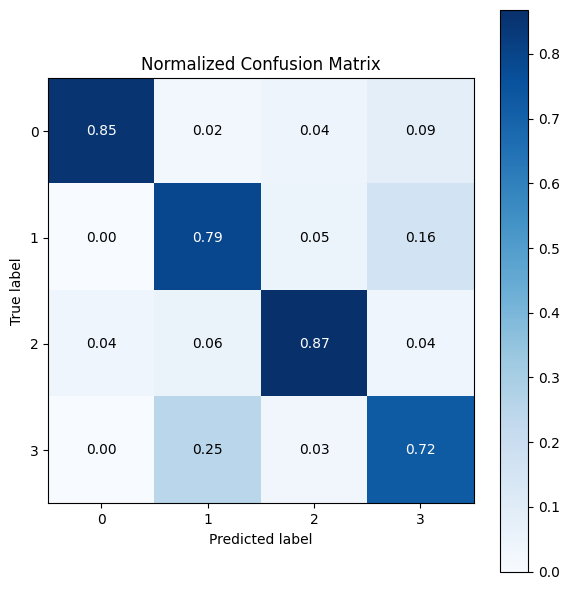


KNeighborsClassifier()_Window51Poly1_PCA0.999_NomRMR
 Original CV Balanced Accuracy: 0.7445
Model: for original_model

[Overall Performance]
   accuracy  balanced_accuracy
0  0.828571           0.822134

[Probabilistic & Calibration]
   log_loss  brier_score
0  3.585154     0.277333
ECE (Expected Calibration Error): 0.1038

[Class-wise Report]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        46
           1       0.83      0.80      0.82        75
           2       0.84      0.92      0.88        53
           3       0.64      0.69      0.67        36

    accuracy                           0.83       210
   macro avg       0.82      0.82      0.82       210
weighted avg       0.83      0.83      0.83       210



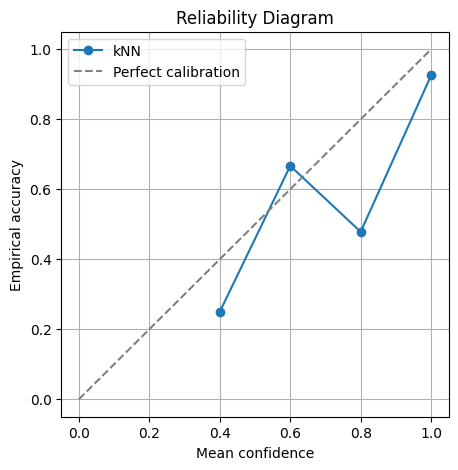

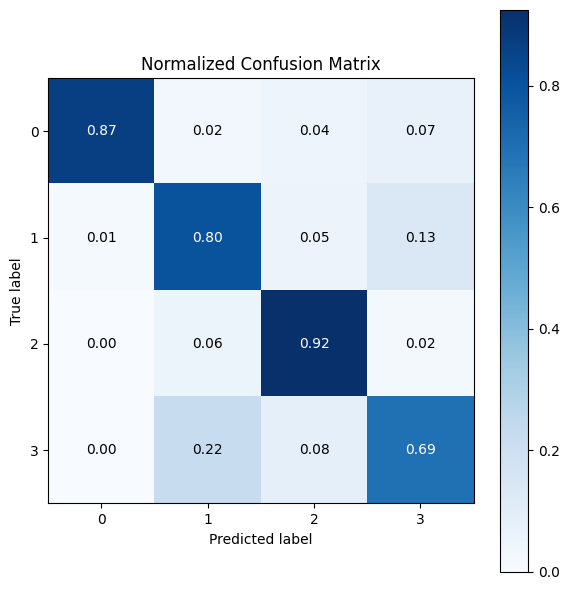

Model: for model

[Overall Performance]
   accuracy  balanced_accuracy
0   0.82381           0.827533

[Probabilistic & Calibration]
   log_loss  brier_score
0  0.890958     0.312565
ECE (Expected Calibration Error): 0.1527

[Class-wise Report]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        46
           1       0.84      0.76      0.80        75
           2       0.88      0.92      0.90        53
           3       0.60      0.78      0.67        36

    accuracy                           0.82       210
   macro avg       0.83      0.83      0.82       210
weighted avg       0.84      0.82      0.83       210



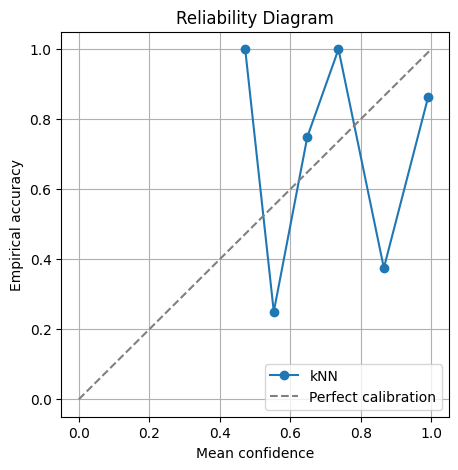

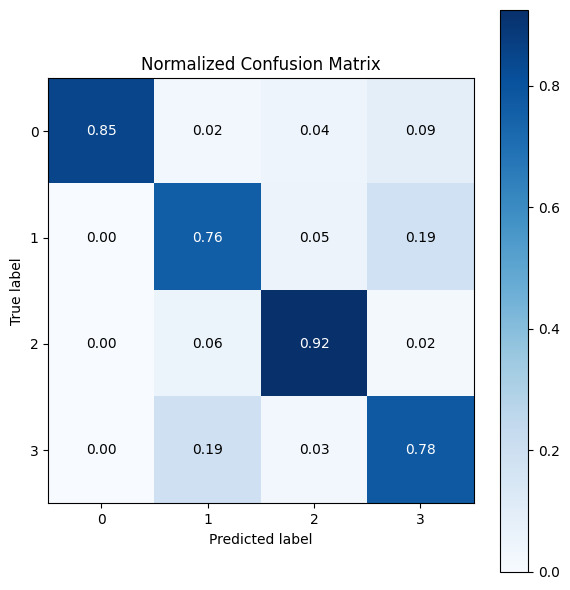

In [191]:
# Sort models by their original CV score to find the champions
sorted_finalists = sorted( aug_study[0], key=lambda x: x['original_row'].mean_test_score, reverse=True )
# Let's pick the Top 3 to avoid cluttering the output
top_finalists = sorted_finalists[:3]

models_to_test = ['original_model', 'model']

for i, model_info in enumerate(top_finalists):
  print(f"\n{'='*80}")
  print(model_info['name'])
  print(f" Original CV Balanced Accuracy: {model_info['original_row'].mean_test_score:.4f}")
  print(f"{'='*80}")

  for model_to_test in models_to_test:
    print(f"Model: for {model_to_test}")

    # Initialize the Metric class
    metric = Metric(
      model=model_info[ model_to_test ],
      X_test=X_test.values if hasattr(X_test, 'values') else X_test,
      y_test=y_test,
    )

    # Run evaluation
    results = metric.evaluate()

    # Display Classification & Probabilistic Metrics in tables
    print("\n[Overall Performance]")
    print(pd.DataFrame([results["classification"]]))

    print("\n[Probabilistic & Calibration]")
    print(pd.DataFrame([results["probabilistic"]]))
    print(f"ECE (Expected Calibration Error): {results['ece']:.4f}")

    # Display Classwise detailed report
    print("\n[Class-wise Report]")
    print(results["classwise"]["classification_report"])

    # Visualization
    metric.plot_reliability_diagram(n_bins=10)
    metric.plot_confusion_matrix(normalize=True, cmap="Blues")

#### 6.) Save results

In [ ]:
base_dir = "../results/final_experiment"
os.makedirs(base_dir, exist_ok=True)

def export_metrics_table(model_list, filename):
  all_rows = []
  for m_info in model_list:
    met = Metric(
      model=m_info['model'],
      X_test=X_test.values if hasattr(X_test, 'values') else X_test,
      y_test=y_test
    )
    res = met.evaluate()
    
    y_pred = m_info['model'].predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    combined_data = {
      "model_display_name": m_info['name'],
      "test_accuracy": res['classification']['accuracy'],
      "test_balanced_acc": res['classification']['balanced_accuracy'],
      "test_log_loss": res['probabilistic']['log_loss'],
      "test_ece": res['ece']
    }
    
    if 'row' in m_info:
      combined_data.update(m_info['row'].to_dict())
        
    for label in ['0', '1', '2', '3']:
      if label in report_dict:
        combined_data[f"class{label}_precision"] = report_dict[label]['precision']
        combined_data[f"class{label}_recall"]    = report_dict[label]['recall']
        combined_data[f"class{label}_f1"]        = report_dict[label]['f1-score']

    all_rows.append(combined_data)
  
  df = pd.DataFrame(all_rows)
  if 'params' in df.columns:
    df['params'] = df['params'].astype(str)
      
  df.to_csv(filename, index=False)
  return df

# Save Grids
pd.DataFrame(grid_stage1.cv_results_).to_csv(f"{base_dir}/grid_stage1_full.csv")
for i, g in enumerate(grids_stage2):
  pd.DataFrame(g.cv_results_).to_csv(f"{base_dir}/grid_stage2_subgrid_{i}.csv")
for i, g in enumerate(grids_stage3):
  pd.DataFrame(g.cv_results_).to_csv(f"{base_dir}/grid_stage3_subgrid_{i}.csv")

print("Exporting Clean Data ...")
export_metrics_table(best_stage3_models, f"{base_dir}/metrics_best_stage3_original.csv")
export_metrics_table(calibrated_models, f"{base_dir}/metrics_calibrated_original.csv")

for scenario_data in aug_study:
  scenario_name = scenario_data[0]['scenario']
  sc_path = f"{base_dir}/scenario_{scenario_name}"
  os.makedirs(sc_path, exist_ok=True)
  
  sc_original_models = []
  sc_calibrated_models = []
  
  for m_info in scenario_data:
    sc_original_models.append({"name": m_info['name'], "model": m_info['original_model']})
    sc_calibrated_models.append({"name": f"Calib_{m_info['name']}", "model": m_info['model']})

  export_metrics_table(sc_original_models, f"{sc_path}/metrics_non_calibrated.csv")
  export_metrics_table(sc_calibrated_models, f"{sc_path}/metrics_calibrated.csv")

print(f"\nDone! All detailed class reports saved to {base_dir}")

Exporting Clean Data ...


/home/pacheco/Documents/FEUP/MYREG/MachineLearning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pacheco/Documents/FEUP/MYREG/MachineLearning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pacheco/Documents/FEUP/MYREG/MachineLearning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to


Done! All detailed class reports saved to ../results/final_experiment
